### Professional League of Legends Player Analysis

The 2019 League of Legends World Championship (Worlds 2019) has sparked discussion on the skill level and effectiveness of its players. There is relative disagreement among casual fans, analysts, and even the professional players themselves on how good the Worlds competitors are.

One interesting element of this discussion is player "uniqueness". An idea that gets thrown around a lot in this discourse is how players are irreplaceable, or how players contribute to their teams in untraditional ways. Doinb, the midlaner for FunPlus Phoenix, for example, is said to be better at roaming and being there for his team - something that doesn't form the precipice of gameplay patterns for the more traditional mid lane superstars in Faker and Rookie who are much more lane-dominant, teamfighting mid laners.

Uniqueness is something that is inherently difficult to quantify - how do we first define player uniqueness and how do we best capture what we're talking about? Here, I attempt to develop a uniqueness index by looking at player performance statistics, transforming them, and then comparing them with those of other player sacross regions and roles in order to add to this discussion.

The data that I will be using for this set of analyses was scraped from https://gol.gg/esports/, which contains different statistics such as win rate, KDA, CSM, Avg WPM, etc. for players from all professional leagues. 

In [1]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import spatial

from adjustText import adjust_text


# Scrape a table of players from ALL regions in 2019 from the webpage
url = 'https://gol.gg/players/list/season-S9/split-ALL/tournament-ALL/position-ALL/week-ALL/'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[-1]

# Create a csv file
df.to_csv('lolprostats.csv')

To take a quick look at the data:

In [2]:
# Drop the first row (redundant row of column names)
df.drop(0, inplace=True)
df.head()

,Player,Position,Games,Win rate,KDA,Avg kills,Avg deaths,Avg assists,CSM,GPM*,...,Avg WPM,Avg WCPM,Avg VWPM,GD@15,CSD@15,XPD@15,FB %,FB Victim,Penta Kills,Solo Kills
1,2188,TOP,33,21.2%,1.7,2.1,2.8,2.9,8.1,376,...,0.45,0.17,0.15,244,7,111,0%,6.1%,0,7
2,369,TOP,84,65.5%,3,2.7,2.6,5,8.3,404,...,0.40,0.19,0.15,1334,13,149,2.4%,0%,0,1
3,3z,TOP,91,54.9%,2.6,2.3,2.4,4.2,8.3,387,...,0.48,0.17,0.19,-23,3,68,17.6%,11%,0,29
4,4LaN,ADC,4,25%,4,3.5,1.5,2.5,10.5,448,...,0.46,0.29,0.19,684,36,506,50%,0%,0,-
5,4LaN,JUNGLE,7,28.6%,1.3,1.1,4.1,4.3,5.5,312,...,0.83,0.31,0.43,-452,1,-26,28.6%,28.6%,0,1


Let's obtain the names of the players in the major regions (LCK, LPL, LEC, LCS)

In [3]:
# Function for further scraping tables from a webpage given the urls and obtaining the player names from each
def get_player_names(url):
    html = requests.get(url).content
    df_list = pd.read_html(html)
    df = df_list[-1]
    df.drop(0, inplace=True)
    
    return df['Player'].tolist()

In [4]:
# Apply the function in order to obtain player names for all regions
LEC = get_player_names('https://gol.gg/players/list/season-ALL/split-ALL/tournament-LEC%20Summer%202019/position-ALL/week-ALL/')
LCK = get_player_names('https://gol.gg/players/list/season-ALL/split-ALL/tournament-LCK%20Summer%202019/position-ALL/week-ALL/')
LCS = get_player_names('https://gol.gg/players/list/season-ALL/split-ALL/tournament-LCS%20Summer%202019/position-ALL/week-ALL/')
LPL = get_player_names('https://gol.gg/players/list/season-ALL/split-ALL/tournament-LPL%20Summer%202019/position-ALL/week-ALL/')

For data cleaning, let's first compile all the players from the major regions:

In [5]:
# Set the index to the player names
df.set_index('Player', inplace=True)

# Obtain the players from all major regions
df = df.loc[LEC + LCK + LCS + LPL]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, Abbedagge to xiye
Data columns (total 22 columns):
Position       405 non-null object
Games          405 non-null object
Win rate       405 non-null object
KDA            405 non-null object
Avg kills      405 non-null object
Avg deaths     405 non-null object
Avg assists    405 non-null object
CSM            405 non-null object
GPM*           405 non-null object
%Dmg           405 non-null object
Avg DPM        405 non-null object
VSPM           405 non-null object
Avg WPM        405 non-null object
Avg WCPM       405 non-null object
Avg VWPM       405 non-null object
GD@15          405 non-null object
CSD@15         405 non-null object
XPD@15         405 non-null object
FB %           405 non-null object
FB Victim      405 non-null object
Penta Kills    405 non-null object
Solo Kills     405 non-null object
dtypes: object(22)
memory usage: 72.8+ KB


In [6]:
# Function for removing the percent sign from certain columns
def remove_percent(list_of_columns):
    for column in list_of_columns:
        df[column] = df[column].apply(lambda x : x.replace('%', ''))

# Ignore chained assignment error
pd.options.mode.chained_assignment = None

remove_percent(['Win rate', 'FB %', 'FB Victim'])

Let's now check for missing values:

In [7]:
df.isnull().sum()

Position       0
Games          0
Win rate       0
KDA            0
Avg kills      0
Avg deaths     0
Avg assists    0
CSM            0
GPM*           0
%Dmg           0
Avg DPM        0
VSPM           0
Avg WPM        0
Avg WCPM       0
Avg VWPM       0
GD@15          0
CSD@15         0
XPD@15         0
FB %           0
FB Victim      0
Penta Kills    0
Solo Kills     0
dtype: int64

There aren't any missing values encoded with NaN or any other standard conventions for doing so. However, there are some players with missing values for the `Solo Kills` column, for example, denoted by the `-` character. Let's replace these as we see fit:

In [8]:
df.replace('-', '0', inplace=True)

Let's only look at players who have played a substantial amount of games (50 is the cutoff used here as 50 games more or less represents around half of the season).

In [9]:
# Drop players who've played less than 50 games, drop duplicates
df['Games'] = df['Games'].astype('float')
df = df[df['Games'] > 50]
df.drop_duplicates(inplace=True)

Let's also convert the values in the DataFrame to numerical ones and extract what we'll need for later.

In [10]:
positions = df['Position']
features = df.columns.values[1:]
allpros = df[features].astype('float', inplace=True)

Finally, let's create regional dataframes and position dataframes:

In [11]:
# Function for indexing into the dataframe with all pro players to obtain dataframes with players from the major regions
def create_league(league_name):
    common = np.intersect1d(np.array(league_name), allpros.index.values)
    return allpros.loc[pd.Index(common)]

LCK = create_league(LCK)
LEC = create_league(LEC)
LCS = create_league(LCS)
LPL = create_league(LPL)

In [12]:
# Function for indexing into the dataframe with all pro players to obtain dataframes with players by role
def create_position(position_name):
    return df[df['Position'] == position_name].drop('Position', axis=1)[features].astype('float', inplace=True)

TOP = create_position('TOP')
JG = create_position('JUNGLE')
MID = create_position('MID')
ADC = create_position('ADC')
SUP = create_position('SUPPORT')

## Principal Component Analysis

Calculating player distance from mean raw stats would not be a very meaningful way to measure uniqueness, as many of the stats are correlated. For example, if a player has a very high win rate, it's likely that he also has a high CSD@15 or FB%. Teams that win more probably yield individual gold differences. To address this issue and make these statistics independent, we'll use Principal Component Analysis, or PCA.

Essentially, we'll transform our data into uncorrelated components that makeup the variance of our initial data. By seeing which statistics contributed to each component the most, we'll have an idea of what how to differentiate between players. We want enough components so as to explain 95% of the variance.

In [13]:
# Tranform values first
def transform_values(df):
    return StandardScaler().fit_transform(df.values)

# Perform PCA, obtain number of principal components where explained variance > 0.95 and list of explained variance
def pca(df):
    
    transformed_values = transform_values(df)
    
    pca = PCA().fit(transformed_values)
    evr = np.cumsum(pca.explained_variance_ratio_)
    
    return evr, [n for n, i in enumerate(evr) if i > 0.95][0] 

In [14]:
evr_all, index_all = pca(allpros)
evr_lck, index_lck = pca(LCK)
evr_lpl, index_lpl = pca(LPL)
evr_lec, index_lec = pca(LEC)
evr_lcs, index_lcs = pca(LCS)

evr_top, index_top = pca(TOP)
evr_jg, index_jg = pca(JG)
evr_mid, index_mid = pca(MID)
evr_adc, index_adc = pca(ADC)
evr_sup, index_sup = pca(SUP)

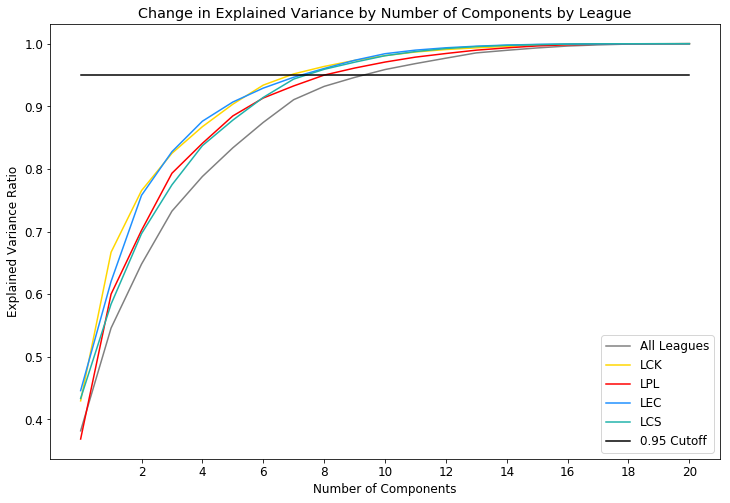

In [15]:
n_components = range(21)
cutoff = np.ones(21) * 0.95

plt.figure(figsize=(12, 8))
plt.rc('font', size=12)

plt.plot(n_components, evr_all, color='grey', label='All Leagues')
plt.plot(n_components, evr_lck, color='gold', label='LCK')
plt.plot(n_components, evr_lpl, color='red', label='LPL')
plt.plot(n_components, evr_lec, color='dodgerblue', label='LEC')
plt.plot(n_components, evr_lcs, color='lightseagreen', label='LCS')
plt.plot(n_components, cutoff, color='black', label='0.95 Cutoff')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(2, 21, 2))

plt.title('Change in Explained Variance by Number of Components by League')
plt.legend(loc='lower right');
plt.savefig('Figures\\EVRbyLeague.pdf')

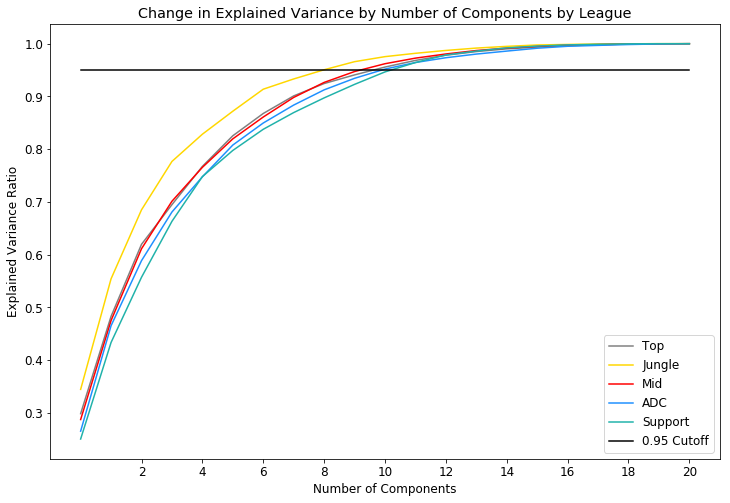

In [16]:
n_components = range(21)
cutoff = np.ones(21) * 0.95

plt.figure(figsize=(12, 8))
plt.rc('font', size=12)

plt.plot(n_components, evr_top, color='grey', label='Top')
plt.plot(n_components, evr_jg, color='gold', label='Jungle')
plt.plot(n_components, evr_mid, color='red', label='Mid')
plt.plot(n_components, evr_adc, color='dodgerblue', label='ADC')
plt.plot(n_components, evr_sup, color='lightseagreen', label='Support')
plt.plot(n_components, cutoff, color='black', label='0.95 Cutoff')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(2, 21, 2))

plt.title('Change in Explained Variance by Number of Components by League')
plt.legend(loc='lower right');
plt.savefig('Figures\\EVRbyRole.pdf')

Each principal component has a loading, which helps us interpret the principal components themselves. Let's take a look at the loadings and how they constitute the components to gain a better understanding of the differentiating factors between players. It'll also be interesting to see how these vary across regions and roles.

In [17]:
# Function for obtaining loadings
def analyze_factors(df, n):
    
    # Perform PCA according to the n_components parameter we obtained before
    pca = PCA(n_components = n)
    comp_pos = pca.fit_transform(df)
    
    # Create dataframes of transformed values
    pca_df = pd.DataFrame(data = comp_pos, columns = ['pc_%s' %i for i in range(1, pca.n_components_ + 1)])
    pca_df['Player'] = df.index.values
    
    # Create dataframes of loadings (choose 5 most important)
    most_important = [np.abs(pca.components_[i]).argpartition(-5)[-5:] for i in range(n)]
    most_important_names = [features[most_important[i]] for i in range(n)]
    
    loadings_dic = {'PC{}'.format(i): most_important_names[i] for i in range(n)}
    loadings_df = pd.DataFrame(loadings_dic)
    
    return pca_df, loadings_df

In [18]:
pca_df_all, factor_loading_all = analyze_factors(allpros, index_all)
pca_df_lck, factor_loading_lck = analyze_factors(LCK, index_lck)
pca_df_lpl, factor_loading_lpl = analyze_factors(LPL, index_lpl)
pca_df_lcs, factor_loading_lcs = analyze_factors(LCS, index_lcs)
pca_df_lec, factor_loading_lec = analyze_factors(LEC, index_lec)

pca_df_top, factor_loading_top = analyze_factors(TOP, index_top)
pca_df_jg, factor_loading_jg = analyze_factors(JG, index_jg)
pca_df_mid, factor_loading_mid = analyze_factors(MID, index_mid)
pca_df_adc, factor_loading_adc = analyze_factors(ADC, index_adc)
pca_df_sup, factor_loading_sup = analyze_factors(SUP, index_sup)

In [19]:
# Let's look at the 5 most important factors for differentiating between players by region
regions_loadings = pd.concat([factor_loading_all.iloc[:, 1], 
                              factor_loading_lck.iloc[:, 1], 
                              factor_loading_lpl.iloc[:, 1], 
                              factor_loading_lcs.iloc[:, 1], 
                              factor_loading_lec.iloc[:, 1]],
                              axis=1)

regions_loadings.columns = ['All', 'LCK', 'LPL', 'LCS', 'LEC']
regions_loadings.to_csv('DataFrames\\regions_loadings.csv', index=False)
regions_loadings

,All,LCK,LPL,LCS,LEC
0,%Dmg,%Dmg,%Dmg,FB %,%Dmg
1,XPD@15,GD@15,GPM*,%Dmg,GD@15
2,GD@15,Avg DPM,Avg DPM,XPD@15,XPD@15
3,GPM*,GPM*,XPD@15,GPM*,Avg DPM
4,Avg DPM,XPD@15,GD@15,Avg DPM,GPM*


In [20]:
# Let's look at the 5 most important factors for differentiating between players by role
roles_loadings = pd.concat([factor_loading_top.iloc[:, 1], 
                            factor_loading_jg.iloc[:, 1], 
                            factor_loading_mid.iloc[:, 1], 
                            factor_loading_adc.iloc[:, 1], 
                            factor_loading_sup.iloc[:, 1]],
                            axis=1)

roles_loadings.columns = ['Top', 'Jungle', 'Mid', 'ADC', 'Support']
regions_loadings.to_csv('DataFrames\\roles_loadings.csv', index=False)
roles_loadings

,Top,Jungle,Mid,ADC,Support
0,Games,Win rate,FB %,GPM*,GPM*
1,GPM*,Avg DPM,GPM*,Games,Avg DPM
2,Avg DPM,GD@15,Solo Kills,Avg DPM,Games
3,GD@15,GPM*,GD@15,XPD@15,XPD@15
4,XPD@15,XPD@15,XPD@15,GD@15,GD@15


## Uniqueness Measurement

Let's create our uniqueness index! To start, let's first find the distance of each player's stats from the average player. We're going to find both manhattan and euclidean distance then plot the players according to both.

In [21]:
# Obtain average of the principal componenets
def get_avg(pca_df):
    return pca_df.iloc[:, :-1].median().values

# Find both the euclidean and manhattan distance from average. Organize into DF
def distance(pca_df):
    
    avg = get_avg(pca_df)
    
    euclidean = []
    manhattan = []
    
    for index, row in pca_df.iterrows():
        euclidean.append(spatial.distance.euclidean(list(row[:-1].values), avg))
        manhattan.append(spatial.distance.cityblock(list(row[:-1].values), avg))
        
    dist_df = pd.DataFrame(list(zip(euclidean, manhattan)), columns = ['euclidean', 'manhattan'])
    dist_df['Player'] = pca_df['Player']
    dist_df = dist_df.sort_values(by = ['manhattan'], ascending = False)
    dist_df = dist_df.reset_index(drop = True)
    
    return dist_df

In [22]:
# Function for plotting the distances
def distance_plot(pca_df, spec):
    
    dist_df = distance(pca_df)
    dist_df.to_csv('DataFrames\\{}_df.csv'.format(spec), index=False)
    
    plt.figure(figsize=(12, 8))
    plt.rc('font', size=12)

    x = list(dist_df['manhattan'][:20])
    y = list(dist_df['euclidean'][:20])
    n = list(dist_df['Player'][:20])

    plt.scatter(x, y)

    texts = []
    for x, y, n in zip(x, y, n):
        texts.append(plt.text(x, y ,n))

    adjust_text(texts)
    
    plt.xlabel('Manhattan Distance from Average')
    plt.ylabel('Euclidean Distance from Average')

Let's apply the above functions to all of the above DataFrames that contain the transformed stats for players across regions and by role.

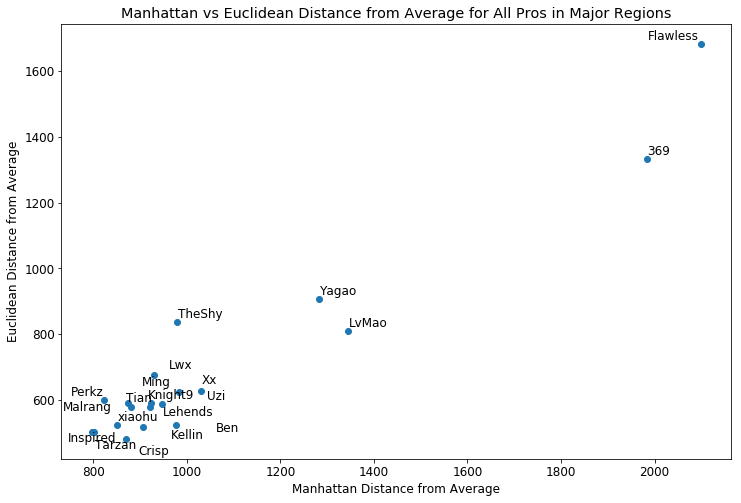

In [23]:
distance_plot(pca_df_all, 'AllPros')
plt.title('Manhattan vs Euclidean Distance from Average for All Pros in Major Regions')
plt.savefig('Figures\\AllProsDist.pdf');

We can see that players Flawless and 369 are incredible stand outs among all pros in the 4 major regions. Let's take a look at their individual statistics just to get a sense of why they're so different according to our index from other professional players:

In [24]:
allpros.loc[['Flawless', '369']]

,Games,Win rate,KDA,Avg kills,Avg deaths,Avg assists,CSM,GPM*,%Dmg,Avg DPM,...,Avg WPM,Avg WCPM,Avg VWPM,GD@15,CSD@15,XPD@15,FB %,FB Victim,Penta Kills,Solo Kills
Player,,,,,,,,,,,,,,,,,,,,,
Flawless,77.0,54.5,3.0,2.2,3.1,7.1,4.8,323.0,12.6,232.0,...,0.84,0.44,0.40,-1082.0,-31.0,-1257.0,0.0,0.0,0.0,0.0
369,84.0,65.5,3.0,2.7,2.6,5.0,8.3,404.0,24.3,451.0,...,0.40,0.19,0.15,1334.0,13.0,149.0,2.4,0.0,0.0,1.0


We can see here that Flawless is "unique" according to our index because his stats are very poor relative to other players in the league with a gold difference at 15 minutes in of -1082 and a creep score difference at 15 minutes of -31. On the flip side, 369 is unique due to having standout metrics in these same categories. In a sense, Flawless is "uniquely bad" whereas 369 is "uniquely excellent".

We might want to take a more specific look at what makes a support player unique by looking at the supposed most unique players by region and by role.

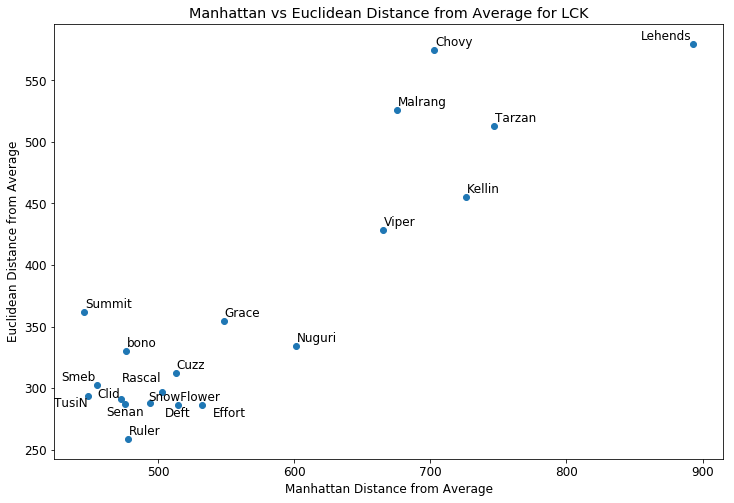

In [25]:
distance_plot(pca_df_lck, 'LCK')
plt.title('Manhattan vs Euclidean Distance from Average for LCK')
plt.savefig('Figures\\LCKDist.pdf');

It's interesting to note that the Griffin players in Chovy, Tarzan, Lehends, and Viper are all clear front runners for "most unique" in addition to Malrang and Kellin, players from the Jin Air Greenwings. Griffin ended both 2019 splits in first whereas Jin Air ended both 2019 splits dead last.

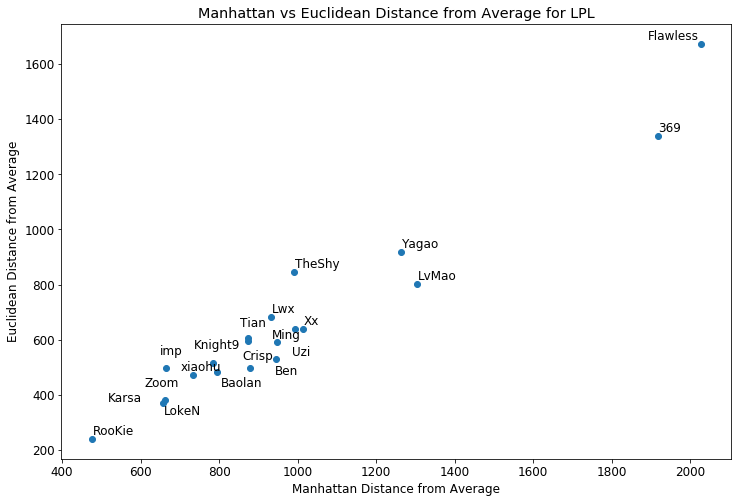

In [26]:
distance_plot(pca_df_lpl, 'LPL')
plt.title('Manhattan vs Euclidean Distance from Average for LPL')
plt.savefig('Figures\\LPLDist.pdf');

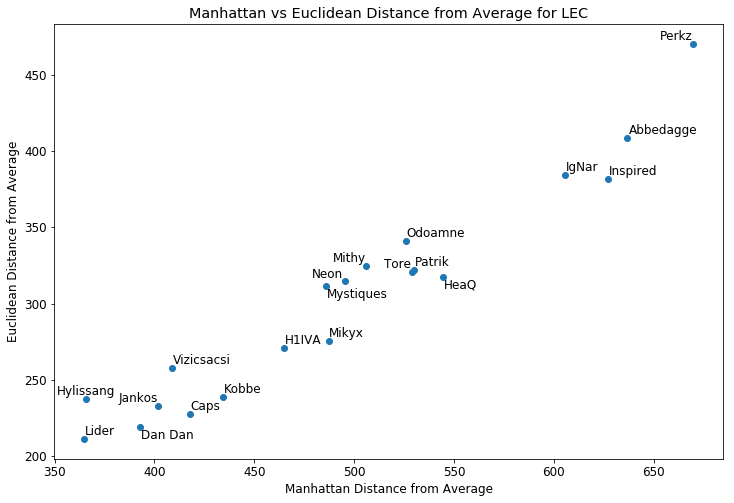

In [27]:
distance_plot(pca_df_lec, 'LEC')
plt.title('Manhattan vs Euclidean Distance from Average for LEC')
plt.savefig('Figures\\LECDist.pdf');

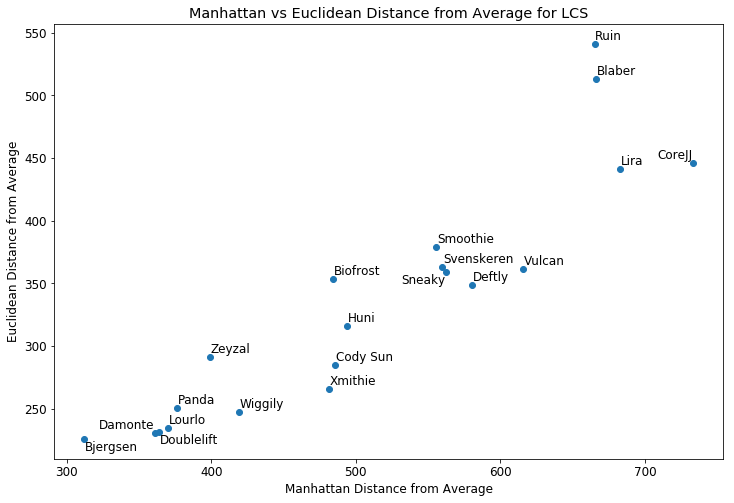

In [28]:
distance_plot(pca_df_lcs, 'LCS')
plt.title('Manhattan vs Euclidean Distance from Average for LCS')
plt.savefig('Figures\\LCSDist.pdf');

What's interesting to note about the western leagues (LEC and LCS) is that there aren't any players that are so far from the rest in performance statistics that the Manhattan distance from the average of the transformed stats is above 800, whereas in the eastern leagues (LCK and LPL) there are.

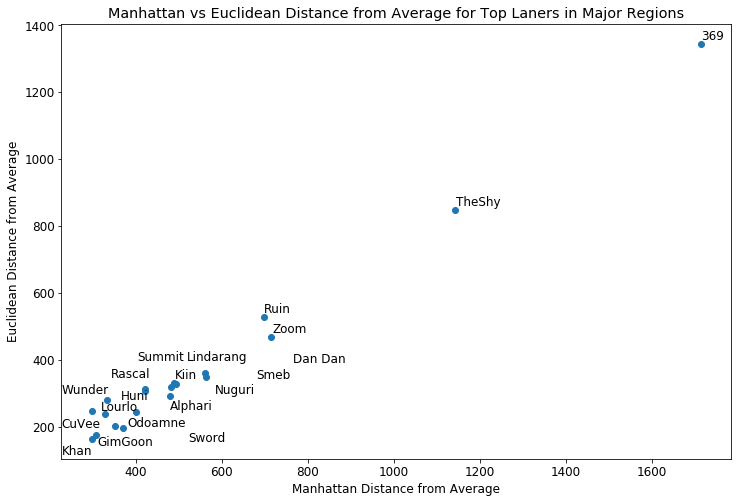

In [29]:
distance_plot(pca_df_top, 'Top')
plt.title('Manhattan vs Euclidean Distance from Average for Top Laners in Major Regions')
plt.savefig('Figures\\TopDist.pdf');

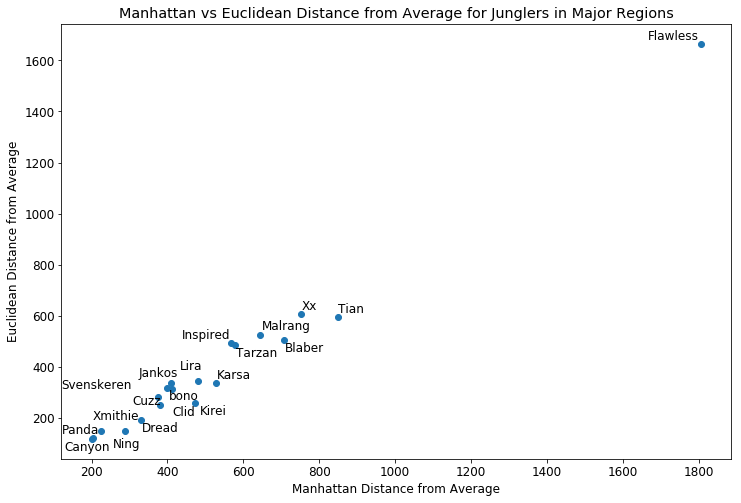

In [30]:
distance_plot(pca_df_jg, 'Jg')
plt.title('Manhattan vs Euclidean Distance from Average for Junglers in Major Regions')
plt.savefig('Figures\\JgDist.pdf');

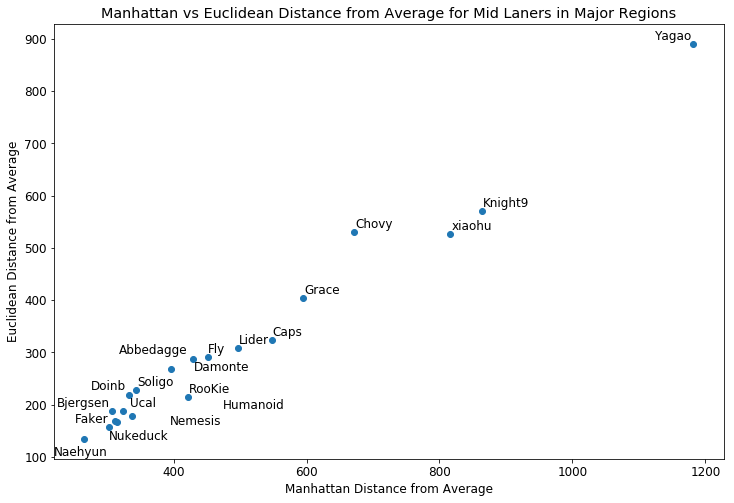

In [31]:
distance_plot(pca_df_mid, 'Mid')
plt.title('Manhattan vs Euclidean Distance from Average for Mid Laners in Major Regions')
plt.savefig('Figures\\MidDist.pdf');

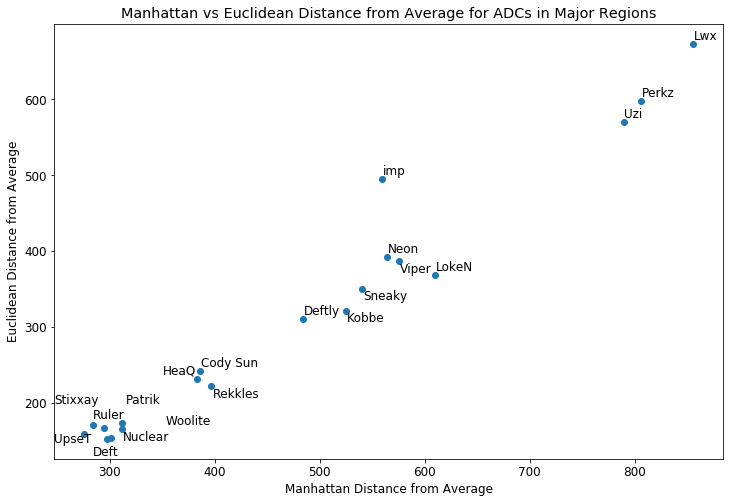

In [32]:
distance_plot(pca_df_adc, 'ADC')
plt.title('Manhattan vs Euclidean Distance from Average for ADCs in Major Regions')
plt.savefig('Figures\\AdcDist.pdf');

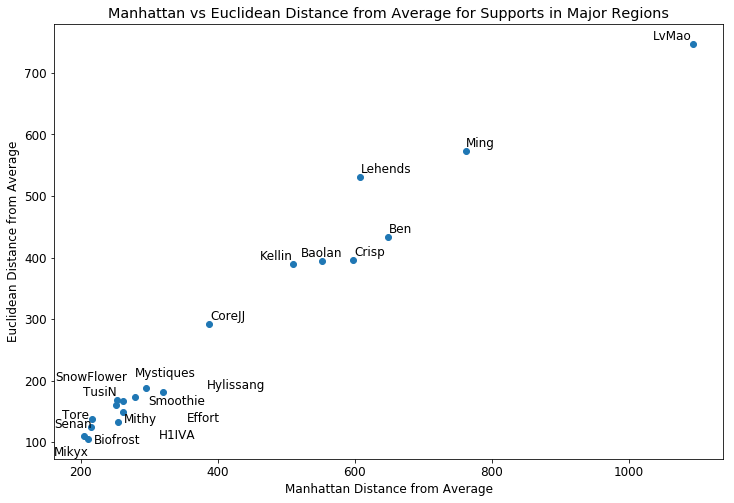

In [33]:
distance_plot(pca_df_sup, 'Sup')
plt.title('Manhattan vs Euclidean Distance from Average for Supports in Major Regions')
plt.savefig('Figures\\SupDist.pdf');

Overall, while this was an interesting way to examine player "uniqueness", it isn't without its drawbacks. Across every region and role, we see the presence of certain players such as LvMao or Flawless that are supposed standout players, as their stats are essentially so "far away" from the average players' stats. 

However, because the distance measures used aren't sensitive to direction by construction, what's not being expressed is the nature of this defined "uniqueness". Is it because the player's statistics or so much lower than the average that drives their distance (Flawless), or is it the opposite (Lehends)? This is something, at this point in the analysis, that can be examined through looking at the individual statistics of the players.

A more apt way to describe a player who is reflected in result of this analysis is "statistical standout", rather than "unique". It's a more difficult problem to capture creative gameplay patterns or original skill expression - things that constitute more of the uniqueness being discussed regard Worlds 2019 competitors - quantitatively. More metadata, such as things that can represent map positioning, damage contribution by champion, or even something like "percentage of shotcalls followed" would be needed in order to better get at this problem. I do not believe such a source of data has been compiled and made publicly available as of yet.